In [3]:
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
import time
from keras.preprocessing.image import load_img #save_img
from keras.applications import vgg16
from keras import backend as K

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [5]:
# dimensions of the generated pictures for each filter.
img_width = 128
img_height = 128

In [6]:
# the name of the layer we want to visualize
# (see model definition at keras/applications/vgg16.py)
layer_name = 'block5_conv1'

In [7]:
# util function to convert a tensor into a valid image
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + K.epsilon())
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_data_format() == 'channels_first':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [4]:
# build the VGG16 network with ImageNet weights
model = vgg16.VGG16(weights='imagenet', include_top=False)
print('Model loaded.')

Model loaded.


In [6]:
# get the symbolic outputs of each "key" layer (we gave them unique names).
layer_dict = dict([(layer.name, layer) for layer in model.layers])
layer_dict

{'block1_conv1': <keras.layers.convolutional.Conv2D at 0x1820561d68>,
 'block1_conv2': <keras.layers.convolutional.Conv2D at 0x1820579358>,
 'block1_pool': <keras.layers.pooling.MaxPooling2D at 0x18205795c0>,
 'block2_conv1': <keras.layers.convolutional.Conv2D at 0x1820561cc0>,
 'block2_conv2': <keras.layers.convolutional.Conv2D at 0x18205b1a20>,
 'block2_pool': <keras.layers.pooling.MaxPooling2D at 0x182059da58>,
 'block3_conv1': <keras.layers.convolutional.Conv2D at 0x18205d7940>,
 'block3_conv2': <keras.layers.convolutional.Conv2D at 0x18205c4dd8>,
 'block3_conv3': <keras.layers.convolutional.Conv2D at 0x1820604be0>,
 'block3_pool': <keras.layers.pooling.MaxPooling2D at 0x1820613828>,
 'block4_conv1': <keras.layers.convolutional.Conv2D at 0x1820637940>,
 'block4_conv2': <keras.layers.convolutional.Conv2D at 0x1820625550>,
 'block4_conv3': <keras.layers.convolutional.Conv2D at 0x1820646400>,
 'block4_pool': <keras.layers.pooling.MaxPooling2D at 0x18206723c8>,
 'block5_conv1': <keras.

In [9]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [10]:
# this is the placeholder for the input images
input_img = model.input

# get the symbolic outputs of each "key" layer (we gave them unique names).
layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])

In [11]:
def normalize(x):
    # utility function to normalize a tensor by its L2 norm
    return x / (K.sqrt(K.mean(K.square(x))) + K.epsilon())

In [12]:
kept_filters = []
for filter_index in range(200):
    # we only scan through the first 200 filters,
    # but there are actually 512 of them
    print('Processing filter %d' % filter_index)
    start_time = time.time()

    # we build a loss function that maximizes the activation
    # of the nth filter of the layer considered
    layer_output = layer_dict[layer_name].output
    if K.image_data_format() == 'channels_first':
        loss = K.mean(layer_output[:, filter_index, :, :])
    else:
        loss = K.mean(layer_output[:, :, :, filter_index])

    # we compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, input_img)[0]

    # normalization trick: we normalize the gradient
    grads = normalize(grads)

    # this function returns the loss and grads given the input picture
    iterate = K.function([input_img], [loss, grads])

    # step size for gradient ascent
    step = 1.

    # we start from a gray image with some random noise
    if K.image_data_format() == 'channels_first':
        input_img_data = np.random.random((1, 3, img_width, img_height))
    else:
        input_img_data = np.random.random((1, img_width, img_height, 3))
    input_img_data = (input_img_data - 0.5) * 20 + 128

    # we run gradient ascent for 20 steps
    for i in range(20):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step

        print('Current loss value:', loss_value)
        if loss_value <= 0.:
            # some filters get stuck to 0, we can skip them
            break

    # decode the resulting input image
    if loss_value > 0:
        img = deprocess_image(input_img_data[0])
        kept_filters.append((img, loss_value))
    end_time = time.time()
    print('Filter %d processed in %ds' % (filter_index, end_time - start_time))

Processing filter 0
Current loss value: 12.395563
Current loss value: 23.77486
Current loss value: 46.167946
Current loss value: 71.94494
Current loss value: 87.80423
Current loss value: 110.362755
Current loss value: 135.23601
Current loss value: 156.49466
Current loss value: 183.74919
Current loss value: 205.75958
Current loss value: 227.12561
Current loss value: 247.15341
Current loss value: 273.5227
Current loss value: 289.4309
Current loss value: 318.96912
Current loss value: 342.35303
Current loss value: 368.17786
Current loss value: 395.2271
Current loss value: 418.64948
Current loss value: 446.8084
Filter 0 processed in 9s
Processing filter 1
Current loss value: 0.0
Filter 1 processed in 0s
Processing filter 2
Current loss value: 8.892509
Current loss value: 25.969177
Current loss value: 58.57068
Current loss value: 93.87091
Current loss value: 124.57747
Current loss value: 155.48915
Current loss value: 192.81741
Current loss value: 219.13596
Current loss value: 256.06683
Curre

Current loss value: 690.02795
Current loss value: 738.3886
Current loss value: 780.9472
Current loss value: 832.38257
Current loss value: 879.0426
Current loss value: 922.09094
Current loss value: 969.80383
Filter 14 processed in 9s
Processing filter 15
Current loss value: 0.37597257
Current loss value: 2.2344103
Current loss value: 14.61223
Current loss value: 35.07994
Current loss value: 67.61151
Current loss value: 116.029236
Current loss value: 160.13431
Current loss value: 196.02481
Current loss value: 241.57028
Current loss value: 278.51724
Current loss value: 315.78067
Current loss value: 348.13382
Current loss value: 386.42126
Current loss value: 423.81656
Current loss value: 457.7342
Current loss value: 496.787
Current loss value: 531.69806
Current loss value: 568.21216
Current loss value: 601.7294
Current loss value: 640.56396
Filter 15 processed in 9s
Processing filter 16
Current loss value: 0.07150558
Current loss value: 6.2771893
Current loss value: 29.12727
Current loss v

Current loss value: 1.8703091
Current loss value: 16.053017
Current loss value: 49.276886
Current loss value: 90.291794
Current loss value: 124.64142
Current loss value: 163.25412
Current loss value: 197.71753
Current loss value: 235.2832
Current loss value: 270.7774
Current loss value: 296.8286
Current loss value: 332.86987
Current loss value: 361.36566
Current loss value: 388.84796
Current loss value: 421.09387
Current loss value: 451.52747
Current loss value: 486.26724
Current loss value: 516.2274
Current loss value: 548.07275
Current loss value: 576.0086
Current loss value: 607.4325
Filter 31 processed in 10s
Processing filter 32
Current loss value: 9.885188
Current loss value: 33.596695
Current loss value: 81.73709
Current loss value: 132.39642
Current loss value: 188.50696
Current loss value: 238.5238
Current loss value: 281.18845
Current loss value: 330.45825
Current loss value: 382.5883
Current loss value: 423.26642
Current loss value: 474.24615
Current loss value: 510.20612
Cu

Current loss value: 598.1106
Current loss value: 637.24786
Current loss value: 669.74
Current loss value: 705.2682
Current loss value: 738.8203
Current loss value: 772.4867
Current loss value: 805.60846
Filter 45 processed in 9s
Processing filter 46
Current loss value: 1.7229271
Current loss value: 7.6588655
Current loss value: 15.044521
Current loss value: 43.659527
Current loss value: 94.41128
Current loss value: 158.86505
Current loss value: 229.7023
Current loss value: 294.7118
Current loss value: 350.70636
Current loss value: 407.95038
Current loss value: 464.92853
Current loss value: 511.09882
Current loss value: 567.47516
Current loss value: 618.4174
Current loss value: 664.7475
Current loss value: 710.34204
Current loss value: 757.39935
Current loss value: 801.2468
Current loss value: 844.817
Current loss value: 891.4856
Filter 46 processed in 8s
Processing filter 47
Current loss value: 3.0601008
Current loss value: 86.97967
Current loss value: 210.33466
Current loss value: 313

Current loss value: 7.621745
Current loss value: 77.95399
Current loss value: 137.39175
Current loss value: 182.5647
Current loss value: 231.11963
Current loss value: 276.63287
Current loss value: 316.2289
Current loss value: 356.46042
Current loss value: 403.84143
Current loss value: 450.5389
Current loss value: 493.93185
Current loss value: 548.10223
Current loss value: 599.10596
Current loss value: 640.5001
Current loss value: 685.0001
Current loss value: 731.28
Current loss value: 777.9125
Current loss value: 819.86725
Current loss value: 865.64435
Current loss value: 907.9055
Filter 62 processed in 11s
Processing filter 63
Current loss value: 0.0
Filter 63 processed in 2s
Processing filter 64
Current loss value: 0.28967607
Current loss value: 23.36935
Current loss value: 69.73906
Current loss value: 148.11655
Current loss value: 258.4748
Current loss value: 370.7293
Current loss value: 454.28503
Current loss value: 554.83417
Current loss value: 645.0238
Current loss value: 716.844

Current loss value: 18.572783
Current loss value: 51.25925
Current loss value: 90.63337
Current loss value: 129.94034
Current loss value: 158.0296
Current loss value: 195.6271
Current loss value: 229.27472
Current loss value: 260.54843
Current loss value: 295.0647
Current loss value: 328.03372
Current loss value: 354.71817
Current loss value: 388.73328
Current loss value: 420.99774
Current loss value: 455.80402
Current loss value: 488.5852
Current loss value: 524.8175
Current loss value: 558.205
Current loss value: 588.8214
Current loss value: 630.8264
Filter 81 processed in 17s
Processing filter 82
Current loss value: 12.593617
Current loss value: 42.26855
Current loss value: 73.49611
Current loss value: 153.54538
Current loss value: 219.3591
Current loss value: 312.17914
Current loss value: 367.8343
Current loss value: 435.96524
Current loss value: 488.24103
Current loss value: 559.094
Current loss value: 632.49805
Current loss value: 691.48145
Current loss value: 771.1959
Current lo

Current loss value: 155.62392
Current loss value: 203.11101
Current loss value: 248.42487
Current loss value: 320.21472
Current loss value: 376.3985
Current loss value: 446.8701
Current loss value: 500.7967
Current loss value: 552.4471
Current loss value: 613.24744
Current loss value: 681.31726
Current loss value: 736.5728
Current loss value: 795.0582
Current loss value: 860.5712
Filter 98 processed in 17s
Processing filter 99
Current loss value: 0.06351582
Current loss value: 1.5196615
Current loss value: 8.74244
Current loss value: 24.846748
Current loss value: 36.842148
Current loss value: 53.868397
Current loss value: 73.9279
Current loss value: 94.70186
Current loss value: 119.738625
Current loss value: 143.09953
Current loss value: 161.20367
Current loss value: 191.34998
Current loss value: 214.77719
Current loss value: 238.15741
Current loss value: 258.64432
Current loss value: 284.46283
Current loss value: 307.521
Current loss value: 332.3177
Current loss value: 360.01196
Curre

Current loss value: 118.950264
Current loss value: 156.7456
Current loss value: 195.1518
Current loss value: 237.0126
Current loss value: 280.41617
Current loss value: 324.27267
Current loss value: 365.7713
Current loss value: 407.07498
Current loss value: 456.0806
Current loss value: 508.84787
Current loss value: 556.99536
Current loss value: 605.60205
Current loss value: 648.7101
Current loss value: 696.52203
Current loss value: 734.75024
Filter 118 processed in 10s
Processing filter 119
Current loss value: 1.8298235
Current loss value: 14.35686
Current loss value: 49.01972
Current loss value: 86.14248
Current loss value: 146.54414
Current loss value: 211.13297
Current loss value: 289.90967
Current loss value: 379.5058
Current loss value: 469.50977
Current loss value: 553.3147
Current loss value: 645.05347
Current loss value: 727.08887
Current loss value: 809.58276
Current loss value: 879.39514
Current loss value: 951.535
Current loss value: 1017.33276
Current loss value: 1082.0889
C

Current loss value: 623.942
Current loss value: 667.5095
Current loss value: 703.78125
Current loss value: 748.9425
Current loss value: 777.41016
Current loss value: 818.7185
Filter 133 processed in 9s
Processing filter 134
Current loss value: 0.0
Filter 134 processed in 1s
Processing filter 135
Current loss value: 0.772856
Current loss value: 11.913519
Current loss value: 48.00065
Current loss value: 83.49751
Current loss value: 129.29199
Current loss value: 182.26363
Current loss value: 222.51324
Current loss value: 269.00885
Current loss value: 309.97052
Current loss value: 350.00027
Current loss value: 385.7909
Current loss value: 424.12054
Current loss value: 452.89856
Current loss value: 494.73944
Current loss value: 525.62933
Current loss value: 566.20605
Current loss value: 600.45435
Current loss value: 639.9212
Current loss value: 672.76874
Current loss value: 709.359
Filter 135 processed in 9s
Processing filter 136
Current loss value: 8.705137
Current loss value: 38.44233
Cur

Current loss value: 195.17009
Current loss value: 273.3148
Current loss value: 332.14563
Current loss value: 382.2562
Current loss value: 447.367
Current loss value: 500.1663
Current loss value: 552.39233
Current loss value: 597.3118
Current loss value: 645.3148
Current loss value: 692.45514
Current loss value: 727.71796
Current loss value: 782.4287
Current loss value: 816.9687
Current loss value: 865.23834
Current loss value: 908.7964
Current loss value: 948.2455
Current loss value: 991.4125
Current loss value: 1033.1272
Filter 149 processed in 9s
Processing filter 150
Current loss value: 21.660944
Current loss value: 55.79558
Current loss value: 101.32979
Current loss value: 155.38922
Current loss value: 206.59862
Current loss value: 259.53326
Current loss value: 312.2784
Current loss value: 362.29883
Current loss value: 411.36664
Current loss value: 458.66833
Current loss value: 498.5883
Current loss value: 547.6758
Current loss value: 592.5674
Current loss value: 640.9911
Current l

Current loss value: 311.96466
Current loss value: 340.7566
Current loss value: 370.1773
Filter 162 processed in 10s
Processing filter 163
Current loss value: 0.2759694
Current loss value: 5.9429765
Current loss value: 22.328161
Current loss value: 77.70422
Current loss value: 151.3236
Current loss value: 258.64233
Current loss value: 352.9768
Current loss value: 452.50397
Current loss value: 540.19556
Current loss value: 632.3915
Current loss value: 727.2501
Current loss value: 794.0254
Current loss value: 872.62573
Current loss value: 927.7297
Current loss value: 1001.96405
Current loss value: 1050.3513
Current loss value: 1111.1364
Current loss value: 1156.4763
Current loss value: 1224.2878
Current loss value: 1269.5164
Filter 163 processed in 9s
Processing filter 164
Current loss value: 0.0
Filter 164 processed in 1s
Processing filter 165
Current loss value: 2.393355
Current loss value: 15.600596
Current loss value: 45.391144
Current loss value: 72.87985
Current loss value: 110.0464

Current loss value: 538.3261
Filter 180 processed in 9s
Processing filter 181
Current loss value: 12.356158
Current loss value: 41.134705
Current loss value: 96.70354
Current loss value: 156.4802
Current loss value: 205.27895
Current loss value: 253.62128
Current loss value: 295.28516
Current loss value: 337.75128
Current loss value: 375.97958
Current loss value: 414.76196
Current loss value: 457.79504
Current loss value: 498.4674
Current loss value: 533.5011
Current loss value: 578.7672
Current loss value: 609.2865
Current loss value: 652.6428
Current loss value: 681.15344
Current loss value: 725.07227
Current loss value: 755.6753
Current loss value: 801.1009
Filter 181 processed in 10s
Processing filter 182
Current loss value: 23.27664
Current loss value: 57.95117
Current loss value: 154.6844
Current loss value: 272.46045
Current loss value: 399.88455
Current loss value: 532.765
Current loss value: 656.09143
Current loss value: 774.37476
Current loss value: 878.25977
Current loss val

In [13]:
# we will stich the best 64 filters on a 8 x 8 grid.
n = 8

# the filters that have the highest loss are assumed to be better-looking.
# we will only keep the top 64 filters.
kept_filters.sort(key=lambda x: x[1], reverse=True)
kept_filters = kept_filters[:n * n]

In [14]:
# build a black picture with enough space for
# our 8 x 8 filters of size 128 x 128, with a 5px margin in between
margin = 5
width = n * img_width + (n - 1) * margin
height = n * img_height + (n - 1) * margin
stitched_filters = np.zeros((width, height, 3))

In [15]:
# fill the picture with our saved filters
for i in range(n):
    for j in range(n):
        img, loss = kept_filters[i * n + j]
        stitched_filters[(img_width + margin) * i: (img_width + margin) * i + img_width,
                         (img_height + margin) * j: (img_height + margin) * j + img_height, :] = img

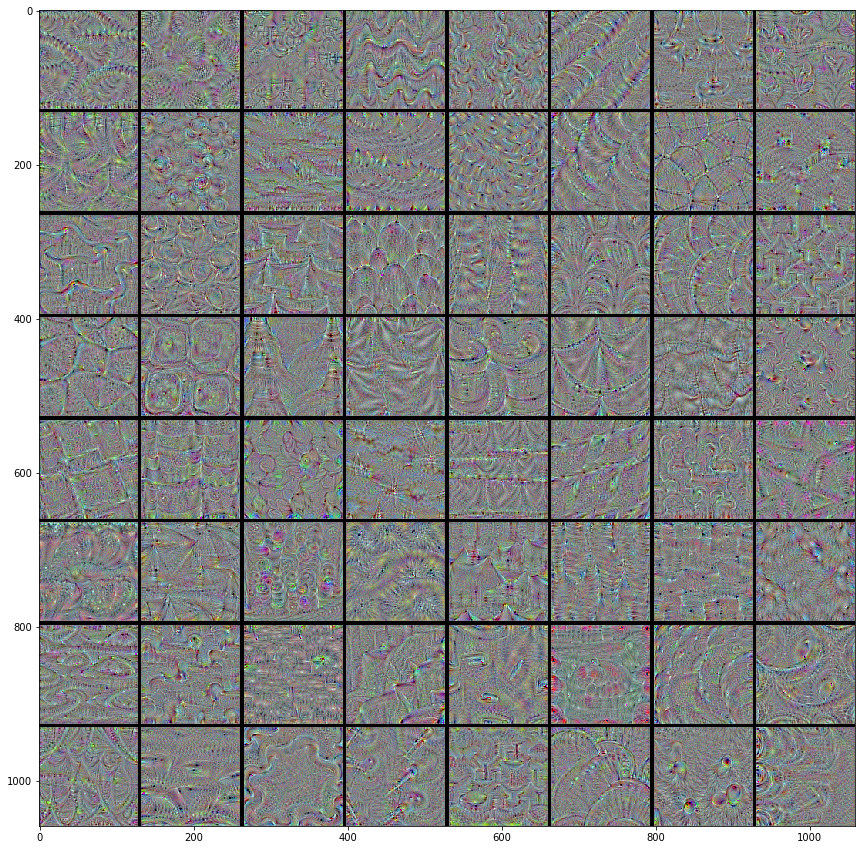

In [42]:
plt.figure(figsize=(15,15)) 
plt.imshow(stitched_filters)
plt.savefig('./images/visualized-filters-of-vgg16.png') 
plt.show()

## In Details

For more detail explaination, kindly visit this site: https://blog.keras.io/how-convolutional-neural-networks-see-the-world.html

<hr/>